# Trabalho 01

Este *notebook* tem como objetivo aplicar todos os conceitos aprendidos no processamento do sinal
para o *dataset -* 8 SSVEP-BCI no modo *offline*.

**Nota:** O arquivo `requirements.txt` contém todas as dependências necessárias.
Para instalar (no linux), basta fazer:

```
$ pip install -r ../requirements.txt
```

In [1]:
# bloco apenas com organizações de imports
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
import json
import matplotlib
import mne
import scipy
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

%matplotlib inline

## Preparação do *dataset* de trabalho

In [2]:
# bloco de declaração dos identificadores de download (google drive) e setup
dataset_ids = {
    1: '1ym3JqI4_ZYNSBLxoF1vNxI5Hsgur_tha',
    2: '1tJ5tHbE-2jwr0gA33Gd873lRPao-e4dF',
    3: '1tXdpY-mser01POaP6Qwixny6LjsXXoXB',
    4: '1T00cliWp5yqqbbWZ7-rf2X4tOUQ-PvIQ',
    5: '1CYsBFMul9zB_vCy0XD7XVfKUl8vihDYZ',
    6: '1io6jdALBKeopELWXahPzuAi6EfYDgviW',
    7: '1YDkheRDPNDR1ujsqqC_SY6cebWHkw9Xt',
    8: '1jjoQJFDCi7O9Q-iaReAPpQnxC-HIKpQi',
}
label_id = '1mD5MXoh6tfQJFXIvdw2MQsEu6vZka6C0'
desc = '14kYNBZYdttqmSS_Vz6Bm_ztG9Uw1MC0y'

# ALTERE O ID DO DATASET DE SUA ESCOLHA AQUI - NO CASO O 8
DS = 8

In [3]:
# download do stataset
gdd.download_file_from_google_drive(file_id=dataset_ids[DS],
                                    dest_path='files/data.npy',
                                    showsize=True)
# download do arquivo de marcações
gdd.download_file_from_google_drive(file_id=label_id,
                                    dest_path='files/labels.npy', showsize=True)

# download do arquivo de descrição
gdd.download_file_from_google_drive(file_id=desc,
                                    dest_path='files/descriptor.json',
                                    showsize=True)

In [4]:
# carregamento do dataset
X = np.load('files/data.npy')
y = np.load('files/labels.npy')
desc_file = open('files/descriptor.json')
descriptor = json.loads(desc_file.read())
desc_file.close()
print('Estruturas => dados', X.shape, 'labels', y.shape)

Estruturas => dados (125, 257, 1205) labels (125,)


Os dados estão estruturados em *numpy arrays*.

O "shape" `(125, 257, 1205)` para os dados EEG de `X`, significa que existem 125 *trials* (tradução aceitável: ensaio, julgamento), 257 *channels* que representam os eletrodos e 1205 dados que representam o potencial mensurado em ponto flutuante. Este é um array com **três dimensões**.

O "shape" `(125,)` para os dados de *labels* ou marcadores `y`, apresentam qual é o eletrodo respectivo a cada *trial*. Os *labels* estão com valores numéricos, o que facilita o processamento, mas não é intuitivo. 

Desta forma, foi preparado um arquivo de descrição no qual é possível saber qual é o rótulo do *dataset*, além de outras informações como a taxa de amostragem (sampling rate), idade, tipo do cabelo (curto, médio ou comprido), sexo, tamanho da touca e se é destro ou canhoto. Veja os dados do voluntário escolhido:

In [5]:
print('Características do voluntário:', descriptor[str(DS)])
print('\nRótulos:', descriptor['frequencies'])
print('\nTaxa de amostragem:', descriptor['sampling_rate'])

Características do voluntário: {'age': '25', 'capsize': 'Adult Medium', 'gender': 'Male', 'hairtype': 'Regular', 'handedness': 'Right'}

Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}

Taxa de amostragem: 250


Apesar do autor do *dataset* apresentar a taxa de amostragem da captura dos dados igual a 250 Hz, o mesmo não foi verificado por meio dos dados. Os dados dos voluntários estão desbalanceados em quantidade, o que não nos permite criar um `numpy.array`, que permite apenas vetores não esparsos. Desta forma, teremos que recalcular a taxa de amostragem (*sample rate*)

In [6]:
# quantidade_de_dados / tempo_do_trial
descriptor['sampling_rate'] = X.shape[-1] / 5
print('Nova taxa de amostragem: {} Hz'.format(descriptor['sampling_rate']))

Nova taxa de amostragem: 241.0 Hz


## Utilizando MNE para representar e trabalhar com os dados

A biblioteca MNE é usada para representar os dados de EEG, facilitando o armazenamento de todas as informações em um único objeto.

Além disso, somente a biblioteca MNE permite executar diversas operações de pré-processamento do *dataset*, além de outras operações utilizadas durante o processamento SSVEP.

### MNE *info descriptor*

O primeiro passo é criar um objeto `info`, que servirá como descrição do objeto MNE. Os valores mais importantes de descrição do objeto são: nome dos eletrodos, taxa de amostragem e tipo do sinal.

In [7]:
# aumentando a escala das figuras no matplotlib (padrão 6. x 4.)
matplotlib.rcParams['figure.figsize'] = [12, 8]

# objeto com o nome dos canais pelo modelo da touca utilizada
montage = mne.channels.make_standard_montage('EGI_256')

# criando o objeto `info` (o restante dos valores já temos)
info = mne.create_info(montage.ch_names,
                       sfreq=descriptor['sampling_rate'],
                       ch_types='eeg')

info.set_montage(montage)
info

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 120.5 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 241.0 Hz
>

Podemos verificar que o nome dos canais não nos ajudou muito. Isto ocorre porque o modelo utilizado não é o "padrão 10-20" ou "padrão 10-05". Desta forma, nome de canais como `O1`, `O2`, `Pz` não estarão explícitos para consulta e outras operações.

Vamos então utilizar informações do artigo, no qual são mostradas alguns mapeamentos destes nomes genéricos (`E1`, `E2`, etc) para os nomes no padrão internacional 10-20:

| 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System |
|:---------:|:------------:|:---------:|:------------:|:---------:|:------------:|:---------:|:------------:|
|     47    |      F7      |     21    |      Fz      |    202    |      T8      |     31    |      NAS     |
|     37    |      Fp1     |    183    |      C4      |    116    |      O1      |     69    |      T7      |
|     36    |      F3      |    170    |      P8      |     94    |      LM      |    190    |      RM      |
|     2     |      F8      |    150    |      O2      |     18    |      Fp2     |    126    |      Oz      |
|    101    |      Pz      |    224    |      F4      |     96    |      P7      |

Além desse mapeamento aproximado, podemos comparar outros, por meio de mapeamentos dos padrões armazenados na própria biblioteca:

EGI 256
Creating RawArray with float64 data, n_channels=256, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


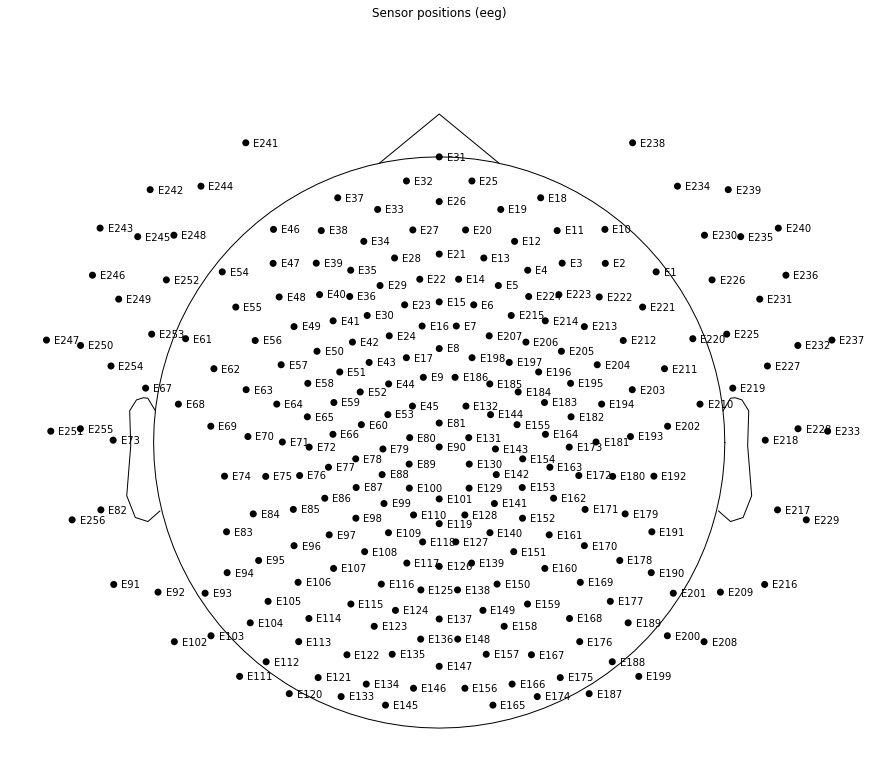

10-20 SYSTEM
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


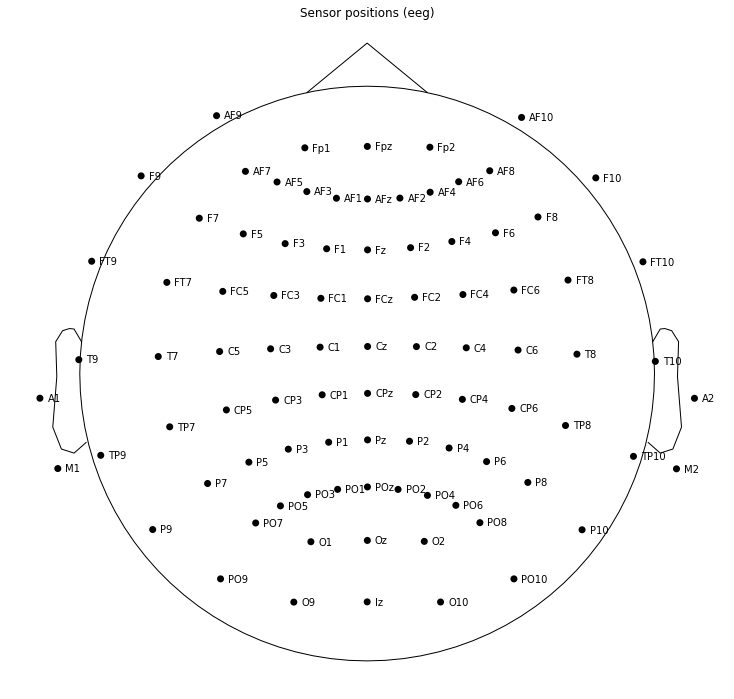

In [8]:
# plotando o padrão EGI 256
print('EGI 256')
montage.plot()

# plotando o padrão 10-20
print('10-20 SYSTEM')

matplotlib.rcParams['figure.figsize'] = [10, 7]
mne.channels.make_standard_montage('standard_1020').plot()
print()

### Criando objeto MNE Epoch

A princípio, precisamos preparar o parâmetro `events` do objeto `EpochArray`, que armazena os marcadores do experimento (aqueles marcadores que estão armazenados no nosso objeto `descriptor`).

Por fim, adicionamos o parâmetro `info` que acabamos de criar.

In [9]:
# o 257º eletrodo é o VREF (referência). Podemos tirá-lo.
X = X[:,:256,:]

# objeto event é uma matriz tridimensional conforme explicado em aula
events = np.array([[i, 0, e] for i, e in enumerate(y)])

# instanciando objeto EpochArray
epoch = mne.EpochsArray(X, info, events=events)
epoch

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

### Iniciando trabalhos com MNE Epoch

Com o objeto MNE criado, podemos realizar as operações.

A primeira coisa que faremos é filtrar alguns eletrodos de maior interesse (p/ experimentos SSVEP) e visualizar os plots básicos.

In [251]:
# Filtrando apenas dados dos eletrodos (O1, Oz e O2), (P7-P7-P8) e (PO7-POz-PO8)
epoch_ex = epoch.copy().pick_channels(['E116', 'E126', 'E150', 
                                       'E96', 'E97', 'E98', 'E99', 'E101', 'E141', 'E152', 'E161', 'E170', 
                                       'E107', 'E108', 'E109', 'E119', 'E140', 'E151', 'E160',
                                      'E117', 'E139', 'E118', 'E127', 'E110'])
# 'E98', E99', 'E101', 'E141','E119'
# epoch_ex = epoch.copy().pick_channels(['E116', 'E126', 'E150', 'E96', 'E97', 
#                                 'E152', 'E161', 'E170', 'E107', 'E108', 'E109', 'E140', 'E151', 'E160'])

epoch_ex

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~27.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

Para demonstrar que estamos apenas com os eletrodos escolhidos, mostramos o shape de ambos os objetos criados.

In [252]:
print(epoch.get_data().shape)
print(epoch_ex.get_data().shape)

(125, 256, 1205)
(125, 24, 1205)


In [283]:
matplotlib.rcParams['figure.figsize'] = [8., 6.]


# CAR 
# epo_ref = mne.set_eeg_reference(epoch_ex, ref_channels=['E116', 'E126', 'E150', 'E96', 'E101', 'E170'])
epo_ref = mne.set_eeg_reference(epoch_ex, ref_channels=['E116', 'E126', 'E150', 
                                       'E98', 'E99', 'E101', 'E141', 'E152', 
                                       'E108', 'E109', 'E119', 'E140', 'E151',
                                      'E117', 'E139', 'E118', 'E127', 'E110'])
epo_ref

# Limitando as frequências
fmin = 5.0
fmax = 14.0

# filtros
epo_hp = epo_ref[0].copy().filter(l_freq=None, h_freq=fmax)
epo_lp = epo_ref[0].copy().filter(l_freq=fmin, h_freq=None)
epo_bp = epo_ref[0].copy().filter(l_freq=fmin, h_freq=fmax)
epo_bp2 = epo_ref[0].copy().filter(l_freq=fmin, h_freq=None)
epo_bp2.filter(l_freq=None, h_freq=fmax)

EEG channel type selected for re-referencing
Applying a custom EEG reference.
Setting up low-pass filter at 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 227 samples (0.942 sec)

Setting up high-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 399 samples (1.656 sec)

Setting up band-pass filter from 5 - 14 Hz

FIR filter parameters
---------------------
Designing a one-

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~27.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

## Etapa de Pré-Processamento

### Filtros temporais

#### High pass filter

In [284]:
# # filtrando os eventos
# for e in ('1', '2', '3', '4', '5'):
#     print("Evento: ", e)
#     # selecionando os trials (1, 3, 9 e 11)
#     # for i in (1, 5, 10, 15, 20):
#         # print("Evento: ", e)
#         # print("Trial: ", i)
#         # epo_hp[e][-i].plot_psd(fmin=fmin, fmax=fmax)
#     # mostrando todos os trials dos eventos
#     matplotlib.rcParams['figure.figsize'] = [10., 6.]
#     epo_hp[e].plot_psd(fmin=fmin,fmax=fmax)
# print()

#### Low pass filter

In [285]:
# # filtrando os eventos
# for e in ('1', '2', '3', '4', '5'):
#     print("Evento: ", e)
#     # selecionando os trials (1, 3, 9 e 11)
#     # for i in (1, 5, 10, 15, 20):
#         # print("Evento: ", e)
#         # print("Trial: ", i)
#         # epo_lp[e][-i].plot_psd(fmin=fmin, fmax=fmax)
#     # mostrando todos os trials dos eventos
#     matplotlib.rcParams['figure.figsize'] = [10., 6.]
#     epo_lp[e].plot_psd(fmin=fmin,fmax=fmax)
# print()

#### Band pass filter

In [286]:
# # filtrando os eventos
# for e in ('1', '2', '3', '4', '5'):
#     print("Evento: ", e)
#     # selecionando os trials (1, 3, 9 e 11)
#     # for i in (1, 5, 10, 15, 20):
#         # print("Evento: ", e)
#         # print("Trial: ", i)
#         # epo_bp[e][-i].plot_psd(fmin=fmin, fmax=fmax)
#     # mostrando todos os trials dos eventos
#     matplotlib.rcParams['figure.figsize'] = [10., 6.]
#     epo_bp[e].plot_psd(fmin=fmin,fmax=fmax)
# print()

#### Band pass filter 2

Evento:  1
    Using multitaper spectrum estimation with 7 DPSS windows


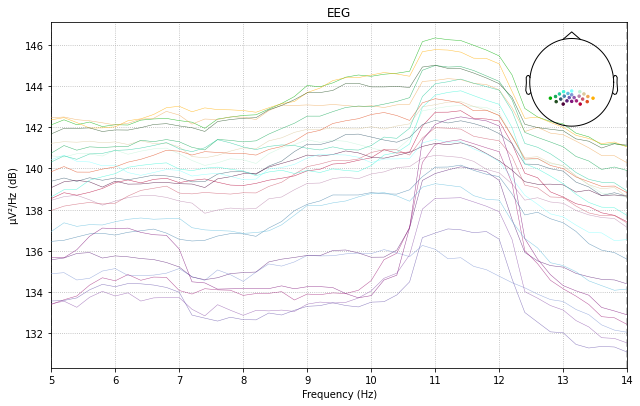

Evento:  2
    Using multitaper spectrum estimation with 7 DPSS windows


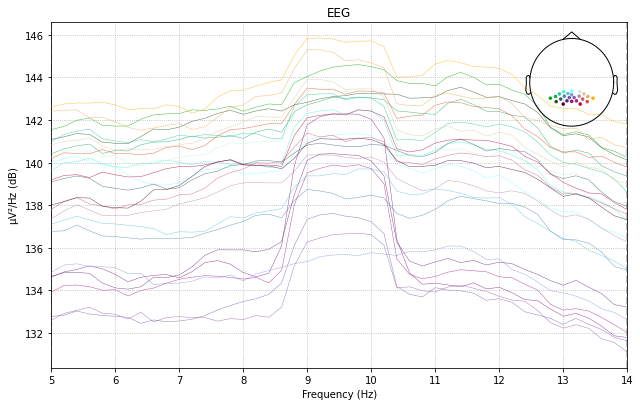

Evento:  3
    Using multitaper spectrum estimation with 7 DPSS windows


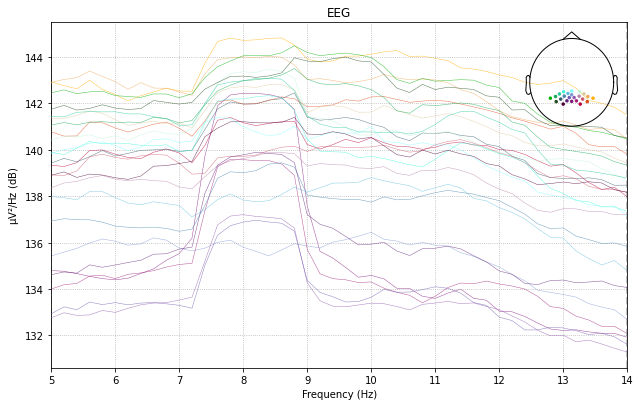

Evento:  4
    Using multitaper spectrum estimation with 7 DPSS windows


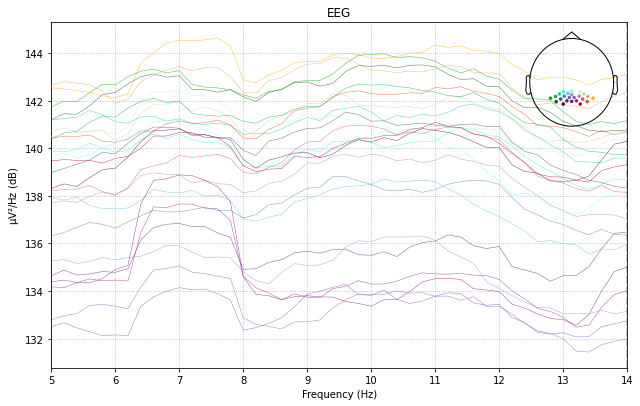

Evento:  5
    Using multitaper spectrum estimation with 7 DPSS windows


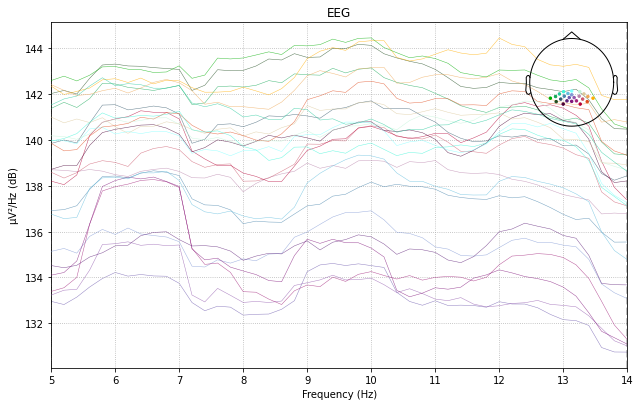

In [287]:
# filtrando os eventos
for e in ('1', '2', '3', '4', '5'):
    print("Evento: ", e)
    # selecionando os trials (1, 3, 9 e 11)
    # for i in (1, 5, 10, 15, 20):
        # print("Evento: ", e)
        # print("Trial: ", i)
        # epo_bp2[e][-i].plot_psd(fmin=fmin, fmax=fmax)
    # mostrando todos os trials dos eventos
    matplotlib.rcParams['figure.figsize'] = [10., 6.]
    epo_bp2[e].plot_psd(fmin=fmin,fmax=fmax)
print()

### Salvando no sistema de arquivos

In [288]:
epo_bp2.save('files/ssvep-epo.fif', overwrite=True)

Overwriting existing file.


In [289]:
# carregamento do dataset (FIF file)
epochs_bp2 = mne.read_epochs('files/ssvep-epo.fif')

Reading files/ssvep-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4995.85 ms
        0 CTF compensation matrices available
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


## Segmentação e criação do vetor de características

### Transformação de domínio

In [290]:
data = epochs_bp2.get_data()
print(data.shape)

# aplicando STFT BP
# _, _, w = stft(data, fs=241, nperseg=32, noverlap=16)
# w = np.swapaxes(w, 3, 4)
freqs, w = scipy.signal.welch(data, fs=241, nperseg=32, noverlap=16)

print(w.shape)

(125, 24, 1205)
(125, 24, 17)


In [291]:
W = np.abs(w) ** 2
# w = np.reshape(w, (125, 13, 17 * 77)) # <= questão de projeto
# w = w.transpose(0, 2, 1)
# w = np.reshape(w, (125 * 1309, 13))
# w = np.reshape(w, (125, 18, 17 * 77))
# w = w.transpose(0, 2, 1)
# w = np.reshape(w, (125 * 1309, 18))
print(W.shape)

(125, 24, 17)


### Extração de características

In [292]:
fmn = np.mean(W, axis=-1)
print('FMN:', fmn.shape)

mx = np.amax(W, axis=-1)
print('MAX:', mx.shape)

mn = np.amin(W, axis=-1)
print('MIN:', mn.shape)

sd = np.std(W, axis=-1) #
print('SD:', sd.shape)

kur = scipy.stats.kurtosis(W, axis=-1)
print('KUR:', kur.shape)

skw = scipy.stats.skew(W, axis=-1)
print('SKW:', skw.shape)

# Root mean square
rms = np.sqrt(np.mean(W, axis=-1))
print('RMS:', rms.shape)

# Root of sum of squares
rss = np.sqrt(np.sum(W, axis=-1))
print('RSS:', rss.shape)

trp = np.trapz(W, axis=-1)
print('TRP:', trp.shape)

trp2 = scipy.integrate.trapz(W, axis=-1)
print('TRP2:', trp2.shape)

absTRP = np.absolute(np.trapz(W, axis=-1))
print('ABSTRP:', absTRP.shape)

abst = np.absolute(np.mean(W, axis=-1))
print('ABST:', abst.shape)

qrt1 = np.quantile(W, .25, axis=-1)
print('QRT1:', qrt1.shape)

qrt2 = np.quantile(W, .50, axis=-1)
print('QRT2:', qrt2.shape)

qrt3 = np.quantile(W, .75, axis=-1)
print('QRT3:', qrt3.shape)

mad = scipy.stats.median_abs_deviation(W, axis=-1)
print('MAD:', mad.shape)

FMN: (125, 24)
MAX: (125, 24)
MIN: (125, 24)
SD: (125, 24)
KUR: (125, 24)
SKW: (125, 24)
RMS: (125, 24)
RSS: (125, 24)
TRP: (125, 24)
TRP2: (125, 24)
ABSTRP: (125, 24)
ABST: (125, 24)
QRT1: (125, 24)
QRT2: (125, 24)
QRT3: (125, 24)
MAD: (125, 24)


In [293]:
# realização das transformações finais (TAREFA)

# finalizando o exemplo com a junção das duas características criadas
features = list()
for feature in (fmn, mx, mn, sd, kur, skw, rms, rss, trp, trp2, absTRP, abst, qrt1, qrt2, qrt3, mad,):
    print(feature.shape)
#     feature = feature.transpose(0, 2, 1)
#     feature = feature.reshape(feature.shape[0] * feature.shape[1],
#                               feature.shape[2])
    features.append(feature)

# vetor de características final
X = np.concatenate(features, axis=-1)
print('Shape dos dados:', X.shape)

(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
(125, 24)
Shape dos dados: (125, 384)


#### Adaptação do vetor de labels

In [294]:
y = np.load('files/labels.npy')
print('Shape original dos labels', y.shape)

size = int(X.shape[0] / y.shape[0])
y = np.concatenate([y for i in range(size)])
print('Shape final dos labels', y.shape)

Shape original dos labels (125,)
Shape final dos labels (125,)


## Classificação

### Métodos de classificação

#### SVM (Support Vector Machine) 

In [295]:
# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True)

In [296]:
# Create a svm Classifier

for kernel in ['linear', 'rbf']:
    clf = SVC(kernel=kernel)
    clf = clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    print('Accuracy: {} - {:.2f}%'.format(kernel, 100*metrics.accuracy_score(y_test, res)))

Accuracy: linear - 73.68%
Accuracy: rbf - 36.84%


#### RF

In [297]:
from sklearn.ensemble import RandomForestClassifier

for n_estimators in [125, 150, 175, 200, 225]:
    regressor = RandomForestClassifier(n_estimators=n_estimators, random_state=25)
    regressor = regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print('Accuracy: n_estimators:{} - {:.2f}%'.format(n_estimators, 100*metrics.accuracy_score(y_test, y_pred)))

Accuracy: n_estimators:125 - 63.16%
Accuracy: n_estimators:150 - 60.53%
Accuracy: n_estimators:175 - 60.53%
Accuracy: n_estimators:200 - 57.89%
Accuracy: n_estimators:225 - 55.26%


#### DT

In [298]:
from sklearn.tree import DecisionTreeClassifier

for criterion in ['gini', 'entropy']:
    for splitter in ['best', 'random']:
        # Create Decision Tree classifer object
        dt = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=4)
        # Train Decision Tree Classifer
        dt = dt.fit(X_train, y_train)
        #Predict the response for test dataset
        dt_y_pred = dt.predict(X_test)
        print('Accuracy: criterion:{} e splitter:{} - {:.2f}%'.format(criterion, splitter, 100*metrics.accuracy_score(y_test, dt_y_pred)))

Accuracy: criterion:gini e splitter:best - 44.74%
Accuracy: criterion:gini e splitter:random - 57.89%
Accuracy: criterion:entropy e splitter:best - 50.00%
Accuracy: criterion:entropy e splitter:random - 42.11%


#### Base

In [299]:
from sklearn.dummy import DummyClassifier

for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy = dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    print('Accuracy: {} - {:.2f}%'.format(strategy, 100*metrics.accuracy_score(y_test, y_pred)))

Accuracy: stratified - 18.42%
Accuracy: most_frequent - 26.32%
Accuracy: prior - 26.32%
Accuracy: uniform - 15.79%


#### MLP

In [300]:
from sklearn.neural_network import MLPClassifier
# MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

for activation in ['identity', 'logistic', 'tanh', 'relu']:
    for solver in ['lbfgs', 'sgd', 'adam']:
        dt = MLPClassifier(hidden_layer_sizes=(5, 2), alpha=1e-5, activation=activation, solver=solver, random_state=1)
        dt = dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        print('Accuracy: activation:{} e solver:{} - {:.2f}%'.format(activation, solver, 100*metrics.accuracy_score(y_test, y_pred)))

/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: activation:identity e solver:lbfgs - 57.89%
Accuracy: activation:identity e solver:sgd - 52.63%


/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy: activation:identity e solver:adam - 44.74%
Accuracy: activation:logistic e solver:lbfgs - 50.00%


/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: activation:logistic e solver:sgd - 26.32%
Accuracy: activation:logistic e solver:adam - 26.32%


/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: activation:tanh e solver:lbfgs - 50.00%
Accuracy: activation:tanh e solver:sgd - 42.11%
Accuracy: activation:tanh e solver:adam - 52.63%
Accuracy: activation:relu e solver:lbfgs - 26.32%
Accuracy: activation:relu e solver:sgd - 26.32%
Accuracy: activation:relu e solver:adam - 26.32%


/home/yyy/rp360/trabalho01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
